# Creating your own dataset from Google Images

*based on a notebook by: Francisco Ingham and Jeremy Howard.

In this tutorial we will see how to easily create an image dataset through Google Images. 

### connect to google drive


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
from fastai.vision import *
import warnings
warnings.simplefilter("ignore",UserWarning)

### Bing image search

Go to [Bing Images](http://https://www.bing.com/images) and search for the images you are interested in. The more specific you are in your search, the better the results and the less manual pruning you will have to do. 

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

    canis lupus lupus -dog -arctos -familiaris -baileyi -occidentalis

When you are sure that the terms you searched are giving good results enter them in the list "keywords". Also choose a name for each search and enter the name in the list "classes". At the end, classes and keywords should have the same length.


In [1]:
!git clone https://github.com/ostrolucky/Bulk-Bing-Image-downloader.git
!cp Bulk-Bing-Image-downloader/bbid.py bbid.py

Cloning into 'Bulk-Bing-Image-downloader'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 166 (delta 8), reused 15 (delta 5), pack-reused 147
Receiving objects: 100% (166/166), 44.65 KiB | 193.00 KiB/s, done.
Resolving deltas: 100% (87/87), done.


In [5]:
project_name='bears'
# classes separated by ","
# Create a list of search keywords
keywords= ['Grizzly bear',
           'Black bear',
           'Teddy bear']
# Create a list of class names.
classes= ['Grizzly',
          'Black',
          'Teddy' ]

# how many images per class? 
img_per_class=600

In [6]:
path = Path(base_dir + 'data/'+project_name)
path.mkdir(parents=True, exist_ok=True)

In [7]:

for kwrd, cls in zip(keywords,classes):
    print(f'Downloading images for class {cls}')
    search_string = f'"{kwrd}"'
    !python bbid.py --limit {img_per_class} -s {search_string} -o {str(path/cls).replace(' ',r'\ ')}

OK: Grizzly-bear.jpg
OK: grizzly-bear-22224-1920x1200.jpg
OK: grizzly-1.png
OK: 23GRIZZLY-superJumbo.jpg
OK: hqdefault.jpg
OK: 22-FILE-PHOTO-LMZ021108grizzlybear-c.jpg
OK: Grizzly_Bear_Info_Images+03.jpg
Invalid image, not saving 1200px-GrizzlyBearJeanBeaufort.jpg
OK: Grizzlybear55.jpg
OK: 12_sep9205.jpg
OK: tnc_88405621.jpg
OK: Grizzly+Bear+Wildlife.jpg
OK: 102487-050-BD924456.jpg
OK: 01grizzlydelisting.ngsversion.145736.jpg
OK: 76151925-b45a-45b6-b62d-9fe0b3cc4c77.JPG
OK: Grizzly_Bear_Info_Images+05.jpg
OK: bear1.jpg
OK: grizzly-bear_Nathan-Rupert-CC-BY-NC-.jpg
OK: 2390661788_951acb14b8_o.jpg
OK: Grizzly-Bear.jpg
OK: Canadian-Grizzly-Bear.jpg
OK: grizzly-bears.jpg
OK: TALKZXTIFJICRVHG62GEVMB3VQ.jpg
OK: ThinkstockPhotos-807913938.jpg
FAIL: 1bearcourt.ngsversion.1440099001838..jpg
OK: 19532120519_0fcf695d7b_k-e1441158706.jpg
OK: Grizzly-Bear-1.jpg
OK: The-Bears-2-1.jpg
OK: _MG_2815-edited_mini.jpg
OK: Bear133-1280x720.jpg
OK: 01-og-grizzly-bear-hunt-Mangelsen-30.jpg
OK: Bear.jpg
OK: im

In [8]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

Grizzly


Black


Teddy


## View data

In [9]:
np.random.seed(42)
bs=64
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,bs=bs,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [10]:
data.classes

['Black', 'Grizzly', 'Teddy']

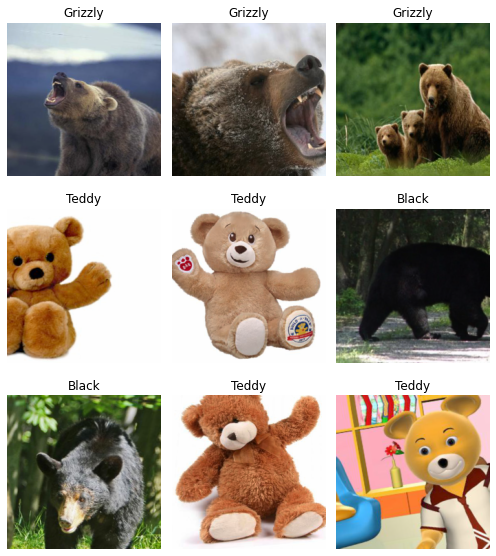

In [11]:
data.show_batch(rows=3, figsize=(7,8))

In [12]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Black', 'Grizzly', 'Teddy'], 3, 912, 228)

## Train model

In [13]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [14]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.750944,0.045846,0.013158,00:16
1,0.384506,0.024687,0.008772,00:15
2,0.240761,0.027166,0.017544,00:15
3,0.180077,0.029036,0.017544,00:15


In [15]:
learn.save('stage-1')

In [16]:
learn.unfreeze()

In [17]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


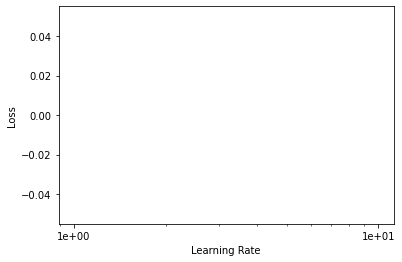

In [18]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.047336,0.030172,0.017544,00:15
1,0.048484,0.031968,0.017544,00:15


In [ ]:
learn.save('stage-2')

## Interpretation

In [ ]:
learn.load('stage-2');

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

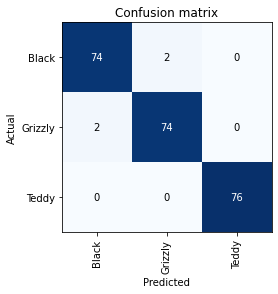

In [21]:
interp.plot_confusion_matrix()

In [22]:
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)


True

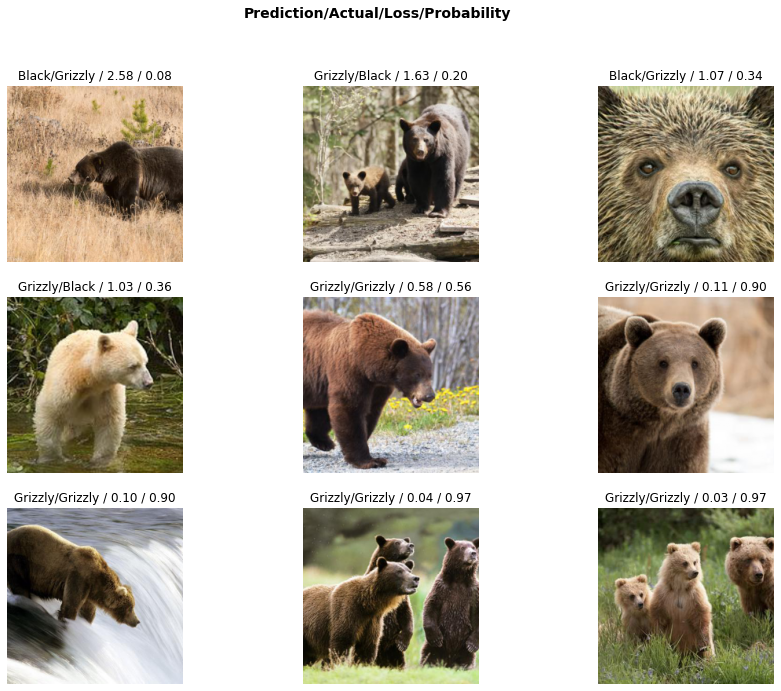

In [23]:
interp.plot_top_losses(9, figsize=(15,11),heatmap=False)


In [24]:

interp.most_confused(min_val=2)

[('Black', 'Grizzly', 2), ('Grizzly', 'Black', 2)]

#Training: resnet50
Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers).
Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [25]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,bs=bs//2,
        ds_tfms=get_transforms(), size=299, num_workers=4).normalize(imagenet_stats)

In [48]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


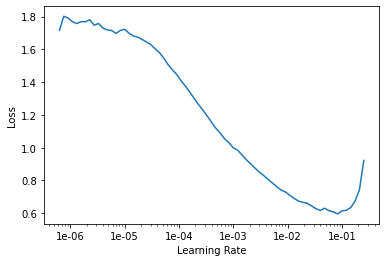

In [27]:
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(4,max_lr=0.001)

epoch,train_loss,valid_loss,error_rate,time
0,0.379020,0.055944,0.008772,00:22
1,0.193224,0.040242,0.013158,00:21
2,0.117193,0.056247,0.021930,00:21
3,0.090466,0.027467,0.013158,00:22


In [ ]:
learn.save('stage-1-r50')

In [29]:
learn.unfreeze()

In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


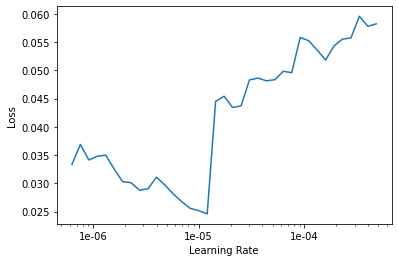

In [31]:
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(2, max_lr=slice(1e-7,1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.033780,0.029913,0.013158,00:23
1,0.035068,0.026685,0.013158,00:23


In [33]:
learn.save('stage-2-r50')

In [34]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()


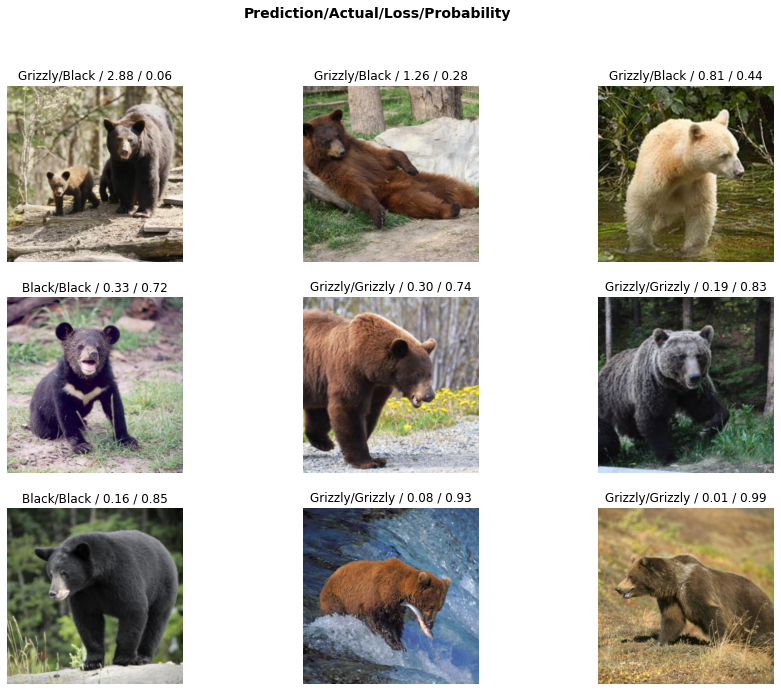

In [35]:
interp.plot_top_losses(9, figsize=(15,11),heatmap=False)

# Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [42]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [36]:
defaults.device = torch.device('cpu')

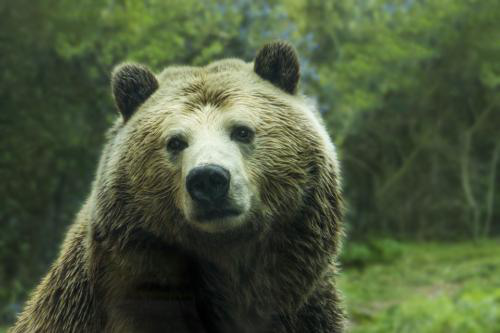

In [58]:
filepath = (path/classes[0]).ls()[0]
img = open_image(filepath)
img

We create our `Learner` in production enviromnent like this, jsut make sure that `path` contains the file 'export.pkl' from before.

In [54]:
learn = load_learner(path)

In [57]:
pred_class,pred_idx,outputs = learn.predict(img)
learn.data.train_ds.y.classes[pred_idx.data.numpy()]

'Grizzly'

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)

## Things that can go wrong

- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs

### Learning rate (LR) too high

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(1, max_lr=0.5)

Total time: 00:13
epoch  train_loss  valid_loss  error_rate       
1      12.220007   1144188288.000000  0.765957    (00:13)



### Learning rate (LR) too low

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Previously we had this result:

```
Total time: 00:57
epoch  train_loss  valid_loss  error_rate
1      1.030236    0.179226    0.028369    (00:14)
2      0.561508    0.055464    0.014184    (00:13)
3      0.396103    0.053801    0.014184    (00:13)
4      0.316883    0.050197    0.021277    (00:15)
```

In [ ]:
learn.fit_one_cycle(5, max_lr=1e-5)

Total time: 01:07
epoch  train_loss  valid_loss  error_rate
1      1.349151    1.062807    0.609929    (00:13)
2      1.373262    1.045115    0.546099    (00:13)
3      1.346169    1.006288    0.468085    (00:13)
4      1.334486    0.978713    0.453901    (00:13)
5      1.320978    0.978108    0.446809    (00:13)



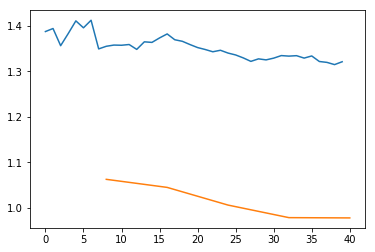

In [ ]:
learn.recorder.plot_losses()

As well as taking a really long time, it's getting too many looks at each image, so may overfit.

### Too few epochs

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=False)

In [ ]:
learn.fit_one_cycle(1)

Total time: 00:14
epoch  train_loss  valid_loss  error_rate
1      0.602823    0.119616    0.049645    (00:14)



### Too many epochs

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

Total time: 06:39
epoch  train_loss  valid_loss  error_rate
1      1.513021    1.041628    0.507326    (00:13)
2      1.290093    0.994758    0.443223    (00:09)
3      1.185764    0.936145    0.410256    (00:09)
4      1.117229    0.838402    0.322344    (00:09)
5      1.022635    0.734872    0.252747    (00:09)
6      0.951374    0.627288    0.192308    (00:10)
7      0.916111    0.558621    0.184982    (00:09)
8      0.839068    0.503755    0.177656    (00:09)
9      0.749610    0.433475    0.144689    (00:09)
10     0.678583    0.367560    0.124542    (00:09)
11     0.615280    0.327029    0.100733    (00:10)
12     0.558776    0.298989    0.095238    (00:09)
13     0.518109    0.266998    0.084249    (00:09)
14     0.476290    0.257858    0.084249    (00:09)
15     0.436865    0.227299    0.067766    (00:09)
16     0.457189    0.236593    0.078755    (00:10)
17     0.420905    0.240185    0.080586    (00:10)
18     0.395686    0.255465    0.082418    (00:09)
19     0.373232    0.2